# TP1 - Ej 1

> Integrantes:

- Aleo, Rodrigo
- Bustillo, Mario
- Luna, Juan Ignacio
- Tassara, Renzo

> Consigna:

Dado un almacén con un layout similar al siguiente, calcular el camino más corto (y la
distancia) entre 2 posiciones del almacén, dadas las coordenadas de estas posiciones,
utilizando el algoritmo A*

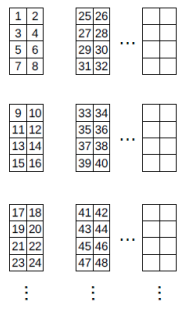

### Importaciones

In [1]:
import pygame
import time

pygame 2.0.1 (SDL 2.0.14, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Variables globales

In [2]:
pygame.init()

L_VENTANA = 540
VENTANA = pygame.display.set_mode((L_VENTANA, L_VENTANA))   #En este objeto ventana es donde hago todo lo que sea gráfico
pygame.display.set_caption('Mapa del Almacen') #nombre que aparece arriba de la ventana

ROJO = (255, 0, 0)
VERDE = (0, 255, 0)
AZUL = (0, 255, 0)
AMARILLO = (255, 255, 0)
BLANCO = (255, 255, 255)
NEGRO = (0, 0, 0)
VIOLETA = (128, 0, 128)
NARANJA = (255, 165 ,0)
GRIS = (128, 128, 128)
TURQUESA = (64, 224, 208)

FILAS = 20
COLUMNAS = 10

#La longitud de cada casilla es la división entera entre la longitud de la ventana y la cantidad de filas (o columnas, ya que es una ventana cuadrada).
ALTO_CASILLA = L_VENTANA // FILAS
ANCHO_CASILLA = L_VENTANA // COLUMNAS

INICIO = None
FINAL = None

CAMINO = [] #acá iré almacenando las casiilas que deben ser recorridas

#Fuente para escribir textos. Se usará para colocar los números de las casillas en el apartado gráfico
fuente_texto = pygame.font.SysFont("Arial", 15, bold = True)

### Clase Nodo


In [3]:
class Nodo:

    def __init__(self, columna_casilla, fila_casilla):
        self.fila_casilla = fila_casilla
        self.columna_casilla = columna_casilla
        self.x = columna_casilla * ANCHO_CASILLA
        self.y = fila_casilla * ALTO_CASILLA
        self.color = BLANCO
        self.padre = None #El padre lo iré actualizando a medida que se vaya formando el camino
        self.numeroAlmacen = 0 #Cada casilla de almacén tenrá un numero
        self.numeroProducto = 0 #Cada cassilla del almacén tendrá un número de producto asociado

        #Estas son las puntuaciones de g (costo de camino) y puntuación f (costo total), que un principio son inf para todos los nodos
        #A medida que los vayamos analizando, los iremos disminuyendo
        self.f = float('inf')
        self.g = float('inf')
    
    def calcular_heuristica(self, nodo_final):
        x1, y1 = self.obtener_posicion()
        x2, y2 = nodo_final.obtener_posicion()
        self.heuristica = abs(x2-x1) + abs(y2-y1)

    def actualizar_f(self):
        self.f = self.g + self.heuristica

    def reiniciar_g_f_padre(self): #Para poder volver a correr el algoritmo en un mismo tablero
        self.g = float('inf')
        self.f = float('inf')
        self.padre = None

    def obtener_posicion(self):
        return self.columna_casilla, self.fila_casilla
    
    def resetear(self):
        self.color = BLANCO

    def hacer_inicio(self):
        self.color = NARANJA
    
    def hacer_objetivo_almacen(self):
        self.color = TURQUESA
    
    def hacer_final(self):
        self.color = AZUL
    
    def hacer_abierta(self):
        self.color = VERDE

    def hacer_cerrada(self):
        self.color = ROJO

    def hacer_obstaculo(self):
        self.color = NEGRO

    def hacer_solucion(self):
        self.color = VIOLETA

    def es_inicio(self):
        return self.color == NARANJA
    
    def es_objetivo_almacen(self):
        return self.color == TURQUESA
    
    def es_final(self):
        return self.color == AZUL
    
    def es_cerrada(self):
        return self.color == ROJO

    def es_abierta(self):
        return self.color == VERDE

    def es_obstaculo(self):
        return self.color == NEGRO

    def pintar_casilla(self):
        pygame.draw.rect(VENTANA,self.color,(self.x, self.y, ANCHO_CASILLA, ALTO_CASILLA))

    def actualizar_vecinos(self,matriz):
        
        self.vecinos = []
        
        #NOTAR QUE PRIMERO MIRO A LOS COSTADOS. A LOS ALMACENES SIEMPRE PUEDO ACCEDER POR ALGUNO DE LOS DOS COSTADOS. POR LO TANTO TOMANDO EL PRIMER ELEMENTO DEL ATRIBUTO VECINOS, PUEDO ACCEDER A LA CASILLA INICIAL

        #Miro para izquierda
        if self.columna_casilla > 0 and not matriz[self.columna_casilla-1][self.fila_casilla].es_obstaculo():
            self.vecinos.append(matriz[self.columna_casilla-1][self.fila_casilla])
        
        #Miro para derecha
        if self.columna_casilla < COLUMNAS-1 and not matriz[self.columna_casilla+1][self.fila_casilla].es_obstaculo():
            self.vecinos.append(matriz[self.columna_casilla+1][self.fila_casilla])        

        #Miro para arriba
        if self.fila_casilla > 0 and not matriz[self.columna_casilla][self.fila_casilla-1].es_obstaculo() and not matriz[self.columna_casilla][self.fila_casilla-1].es_objetivo_almacen():
            self.vecinos.append(matriz[self.columna_casilla][self.fila_casilla-1])

        #Miro para abajo
        if self.fila_casilla < FILAS-1 and not matriz[self.columna_casilla][self.fila_casilla+1].es_obstaculo() and not matriz[self.columna_casilla][self.fila_casilla+1].es_objetivo_almacen():
            self.vecinos.append(matriz[self.columna_casilla][self.fila_casilla+1])
        


    def esEspacioEnAlmacen(self):
        return self.numeroAlmacen > 0

### Funciones de dibujo


In [4]:
def dibujarLineas():
    #Dibujo líneas verticales
    for i in range(COLUMNAS):
        pygame.draw.line(VENTANA,GRIS,(i*ANCHO_CASILLA,0),(i*ANCHO_CASILLA,L_VENTANA))
        #Dibujo líneas horizontales
        for j in range(FILAS):
            pygame.draw.line(VENTANA,GRIS,(0,j*ALTO_CASILLA),(L_VENTANA,j*ALTO_CASILLA))


def dibujarTexto(texto, fuente, color, x, y):
    img = fuente.render(texto, True, color)
    VENTANA.blit(img, (x,y))
    
    
def dibujarNumeros(matriz):    
    for fila in matriz:
        for nodo in fila:
            if nodo.numeroProducto>0:
                dibujarTexto(str(nodo.numeroProducto), fuente_texto, BLANCO, nodo.x , nodo.y)

#Esta función es la encargada de dibujar todos los elementos de la ventana por cada frame
def dibujar(matriz):
    
    #Primero pinto de blanco el fondo
    VENTANA.fill(BLANCO)

    #Pinto las casillas
    for fila in matriz:
        for nodo in fila:
            nodo.pintar_casilla()
    
    #Dibujo las líneas. Si lo hago antes de pintar las casillas, quedarán tapadas
    dibujarLineas()
    
    #dibujo los números al final de todo
    dibujarNumeros(matriz)

    #escribo "inicio" y "final" si ya han sido seleccionadas las casillas
    if INICIO: dibujarTexto("Inicio", fuente_texto, NEGRO, INICIO.x, INICIO.y)
    #if FINAL: dibujarTexto("Final", fuente_texto, BLANCO, FINAL.x, FINAL.y)


    #Con esto voy actualizando la pantalla
    pygame.display.update()

### Funciones lógicas

In [5]:
def crearMatrizNodos():
    matriz = []
    for i in range(COLUMNAS):
        matriz.append([])
        for j in range(FILAS):
            nodo = Nodo(i,j)
            matriz[i].append(nodo)
    return matriz

def obtenerPosClick(pos): #convierte la posición x-y del mouse en columna-fila
    x_click, y_click = pos
    columna = x_click // ANCHO_CASILLA
    fila = y_click // ALTO_CASILLA
    return columna,fila

def guardarCamino(matriz, nodo_final):
    flag = True
    nodo = nodo_final
    caminoCorto = [] #Lista auxiliar donde se guardan nodos pero desde el final hasta el iniciao (como recorriendo en camino inverso)
    while flag:
        #Como el robot no entra al espacio de almacén, su última posición debe ser una casilla antes.
        if nodo.padre and nodo.padre!=INICIO:
            nodo = nodo.padre
            caminoCorto.append(nodo)
        
        #Una vez recorro toda la herencia
        else:
            for nodo in reversed(caminoCorto): #Acá guardo la lista pero esta vez bien ordenada desde el inicio al final
                CAMINO.append(nodo)
            caminoCorto = []
            flag = False

    return False


def dibujarCamino(matriz):
    
    for nodo in CAMINO:
        nodo.hacer_solucion()
        dibujar(matriz)

#Esta función será la encargada de limpiar el tablero por completo
def limpiar_tablero(matriz):

    for fila in matriz:
        for nodo in fila:
            if nodo.es_abierta() or nodo.es_cerrada():
                nodo.resetear()
    
    global CAMINO
    CAMINO = []
    

Tengo que asignar a las casillas del almacén un número a cada una. El resto quedarán en cero. Las casillas con número serán posibles elecciones de casilla objetivo. Debe quedar algo así:

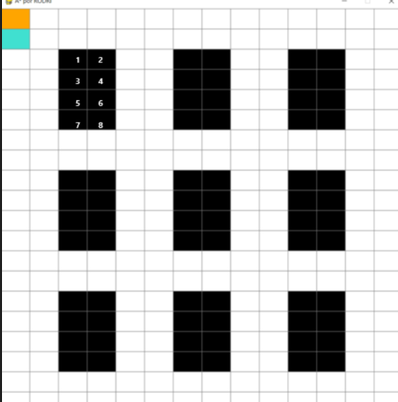

Correción: se necesita tener más de 100 espacios en al almacen, por lo que se agrega una fila extra de almacenamiento

Corrección 2: se redujo significativamente la cantidad de espacios de almacén para disminuir el tiempo de cómputo sobre todo para el ejercicio 3 de algoritmo genético.

Asigno números

In [6]:
def asignarNumero(matriz):
    
    #De forma muy rústica le pongo números a cada elemento del almácen.

    #ELEMENTOS DE LA IZQUIERDA
    conteo = 1
    conjuntoDe8(matriz, 2, 2, conteo) #asigno del 1 al 8
    conteo += 8
    conjuntoDe8(matriz, 6, 2, conteo) #asigno del 9 al 16
    #conteo += 8
    #conjuntoDe8(matriz, 10, 2, conteo) #asigno del 17 al 24
    #conteo += 8
    #conjuntoDe8(matriz, 14, 2, conteo)

    #ELEMENTOS DEL CENTRO
    conteo += 8
    conjuntoDe8(matriz, 2, 8, conteo) #asigno del 25 al 32
    conteo += 8
    conjuntoDe8(matriz, 6, 8, conteo) #asigno del 33 al 40
    #conteo += 8
    #conjuntoDe8(matriz, 10, 8, conteo) #asigno del 41 al 48
    #conteo += 8
    #conjuntoDe8(matriz, 14, 8, conteo)

    #ELEMENTOS DE LA DERECHA
    conteo += 8
    conjuntoDe8(matriz, 2, 14, conteo) #asigno del 49 al 56
    conteo += 8
    conjuntoDe8(matriz, 6, 14, conteo) #asigno del 54 al 64
    #conteo += 8
    #conjuntoDe8(matriz, 10, 14, conteo) #asigno del 65 al 72
    #conteo += 8
    #conjuntoDe8(matriz, 14, 14, conteo)

    #AGREGO UNA MÁS A LA DERECHA PARA TENER MÁS DE 100 POSICIONES
    #conteo += 8
    #conjuntoDe8(matriz, 2, 20, conteo) 
    #conteo += 8
    #conjuntoDe8(matriz, 6, 20, conteo)
    #conteo += 8
    #conjuntoDe8(matriz, 10, 20, conteo) 
    #conteo += 8
    #conjuntoDe8(matriz, 14, 20, conteo)


def conjuntoDe8(matriz, xi, yi, conteo): #xi e yi determinan la posición del nodo más arriba a la izquierda del conjunto de 8
    for j in range(yi,yi+4):
        for i in range(xi, xi+2):
            matriz[i][j].numeroAlmacen = conteo
            matriz[i][j].numeroProducto = conteo #inicialmente cada producto compartirá el mismo número de almacen, esto cambiará en el punto 3 de algoritmo genético
            matriz[i][j].hacer_obstaculo()
            conteo += 1


### Algoritmo A*


In [7]:
#F(n) = C(n)+H(n) el valor para cierto nodo es la suma entre el costo y le heurística.
def algoritmoAestrella(matriz, nodo_inicial, nodo_objetivo):


    #Conociendo el nodo final, calculo la heurística para cada nodo de la matriz
    for fila in matriz:
        for nodo in fila:
            nodo.calcular_heuristica(nodo_objetivo)
            #De paso reinicio el valor g y f de cada nodo (para poder volver a correr el algorimo en un mismo tablero)
            nodo.reiniciar_g_f_padre()

    #Declaro los valores de costo de camino y puntaución f para el nodo inicial
    nodo_inicial.g = 0
    nodo_inicial.actualizar_f()

    #Agrego inicio a la cola de análisis
    cola = [nodo_inicial]

    flag = True
    while flag:

        #Selecciono el nodo con menor f en la cola
        f_min = float('inf')

        if len(cola)==0: #Esto es para evitar que falle el programa cuando no hay nada en la lista cola
            print('No hay solucion')
            return False

        for nodo in cola:
            if nodo.f < f_min:
                f_min = nodo.f
                seleccion = nodo

        cola.remove(seleccion)  #Elimino de la cola al nodo que se analizará a continuación
    
        #A cada vecino le actualizaré el valor g SOLO SI EL VALOR g NUEVO ES MENOS AL QUE YA TENÍAN
        #Tener en cuenta que inicialmente g tiene valor infinito.
        #De paso si, el g cambia, le tengo que cambiar el padre al vecino. Esto lo hago para que una casilla, que ya fue analizada, pueda tener un nuevo camino pero más corto.
        for vecino in seleccion.vecinos:

            #Caso donde el vecino es el nodo objetivo
            if vecino == nodo_objetivo:
                vecino.padre = seleccion
                
                #Meto las casillas que conforman el camino en una lista
                guardarCamino(matriz, vecino) 
                
                #Reinicio el sistema de padres para poder luego volver a aplicar A*
                for fila in matriz:
                    for nodo in fila:
                        nodo.padre = None  
                
                #Vuelvo los nodos importantes a su estado inicial
                nodo_objetivo.hacer_objetivo_almacen()
                INICIO.hacer_inicio()

                return False
                

            elif seleccion.g+1 < vecino.g:
                vecino.g = seleccion.g+1 #Actualizo el costo de camino del vecino
                vecino.padre = seleccion #El nuevo padre del vecino será el nodo seleccionado
        
            #Actualizo los valores f de cada vecino
            f_viejo = vecino.f #guardo el valor f antes de cambiarlo para analizarlo más tarde
            vecino.actualizar_f()

            #Pongo al vecino en cola de análisis sólo si su nuevo valor f es menor al que tenía, y si no es un obstaculo
            #Tampoco puede ser un objetivo_almacen. Esto es importante para el Ej2 de temple simulado, donde pueden haber 2 objetivos_almacen pegados.
            if vecino.f < f_viejo and not vecino.es_obstaculo() and not vecino.es_objetivo_almacen():
                #Lo pinto de verde para indicar que está en cola de análisis
                vecino.hacer_abierta()
                cola.append(vecino)
        
        
        #Finalmente, pinto el nodo analizado de rojo para indicar que ya ha sido analizado
        if not seleccion.es_inicio():    #Para que no se pinte de rojo la casilla inicial
            seleccion.hacer_cerrada()
        
        #time.sleep(3)
        
        dibujar(matriz)

### Main

In [8]:
def main():
    matriz = crearMatrizNodos()
    asignarNumero(matriz)

    global INICIO
    global FINAL
    global CAMINO

    run = True
    while(run):
        
        #En este caso el inicio siempre es el nodo más arriba a la izquierda
        #inicio = matriz[0][0] #Llevo registro de si ya puse o no la casilla de inicio
        #matriz[0][0].hacer_inicio()

        dibujar(matriz)

        #Capturo los eventos que ocurran durante la ejecucion
        for event in pygame.event.get():
            
            #Si presiono la cruz para finalizar el programa
            if event.type == pygame.QUIT:
                run = False
            
            #Si presiono click izquierdo
            if pygame.mouse.get_pressed()[0]:
                pos = pygame.mouse.get_pos()
                columna, fila = obtenerPosClick(pos)
                nodo = matriz[columna][fila]

                if not INICIO and not nodo.esEspacioEnAlmacen():
                    nodo.hacer_inicio()
                    INICIO = nodo

                elif not FINAL and nodo.esEspacioEnAlmacen() and nodo != INICIO:
                    nodo.hacer_objetivo_almacen()
                    FINAL = nodo
    

            #Si presiono click derecho borro solo esa selección
            if pygame.mouse.get_pressed()[2]:
                pos = pygame.mouse.get_pos()
                columna, fila = obtenerPosClick(pos)
                nodo = matriz[columna][fila]
                
                if nodo.es_inicio():
                    nodo.resetear()
                    INICIO = None

                if nodo.es_objetivo_almacen():
                    nodo.hacer_obstaculo()
                    FINAL = None


            #Si detecta una presión de tecla
            if event.type == pygame.KEYDOWN:

                #Si apreto r para resetear el tablero
                if event.key == pygame.K_r:
                    for fila in matriz:
                        for nodo in fila:
                            nodo.resetear()
                    #Creo nuevamente los espacios de almacen
                    asignarNumero(matriz)
                    #Reinicio INICIO y FINAL
                    INICIO = None
                    FINAL = None
                    #Limpio el vector CAMINO
                    CAMINO = []
                    print("||||||||||||||||||||||||||||||||||||||||||||||||||")

                #Si apreto barra espaciadora para empezar algoritmo
                elif event.key == pygame.K_SPACE and INICIO and FINAL:
                    for fila in matriz:
                        for nodo in fila:
                            nodo.actualizar_vecinos(matriz) #De esta forma, relaciono todos los nodos con sus vecinos
                    
                    T_inicio = time.time()

                    algoritmoAestrella(matriz, INICIO, FINAL)

                    T_final = time.time()

                    print(f"Tiempo ejecución A*: {T_final-T_inicio} s")

                    #Dibujo el camino final
                    dibujarCamino(matriz)

                    print("Casillas a recorrer:")

                    for nodo in CAMINO:
                        print("({},{})".format(nodo.columna_casilla, nodo.fila_casilla))
                       
                    print("Costo de camino: {}".format(len(CAMINO)))                    

        
    pygame.quit()

# EJECUCION

In [9]:
main()



Tiempo ejecución A*: 0.17190313339233398 s
Casillas a recorrer:
(1,0)
(2,0)
(3,0)
(4,0)
(5,0)
(5,1)
(5,2)
(5,3)
(5,4)
(5,5)
(5,6)
(6,6)
(7,6)
(7,7)
(8,7)
(8,8)
Costo de camino: 16
||||||||||||||||||||||||||||||||||||||||||||||||||
Tiempo ejecución A*: 0.34780025482177734 s
Casillas a recorrer:
(1,19)
(2,19)
(3,19)
(4,19)
(5,19)
(5,18)
(5,17)
(5,16)
(5,15)
(5,14)
(5,13)
(5,12)
(5,11)
(5,10)
(5,9)
(5,8)
(5,7)
(6,7)
(7,7)
(7,6)
(8,6)
(8,5)
(8,4)
(8,3)
(8,2)
Costo de camino: 25
||||||||||||||||||||||||||||||||||||||||||||||||||
Tiempo ejecución A*: 0.3411569595336914 s
Casillas a recorrer:
(8,19)
(7,19)
(6,19)
(5,19)
(4,19)
(4,18)
(4,17)
(4,16)
(4,15)
(4,14)
(4,13)
(4,12)
(4,11)
(4,10)
(4,9)
(4,8)
(4,7)
(3,7)
(2,7)
(2,6)
(1,6)
(1,5)
(1,4)
(1,3)
(1,2)
Costo de camino: 25
||||||||||||||||||||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||||||||||||||||||||
Tiempo ejecución A*: 0.2738354206085205 s
Casillas a recorrer:
(2,19)
(3,19)
(4,19)
(5,19)
(5,18)
(5,17)
(5,16)
(5,15)
(5